In [208]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vit_b_16, ViT_B_16_Weights
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from PIL import Image
from transformers import ViTFeatureExtractor, ViTModel
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import plotly.express as px

In [209]:
# Scelta modelli
model_a = {'cips'}
model_b = {'taming_transformer'}

In [210]:
class ImageFolder(Dataset):

    def __init__(self, root_dir, model_a, model_b, metadata_name='metadata.csv', nrows=None, transform=None, random_state=42):
        self.root_dir = Path(root_dir)
        self.metadata_name = metadata_name
        self.transform = transform
        self.random_state = random_state

        # Carica campioni etichettati 0 e 1
        samples_a = self._load_samples(model_a, label=0, nrows=nrows)
        samples_b = self._load_samples(model_b, label=1, nrows=nrows)

        print(f"Caricate immagini: '{model_a}': {len(samples_a)} — '{model_b}': {len(samples_b)}")
        if len(samples_a) == 0 or len(samples_b) == 0:
            raise ValueError(f"Dataset non valido: una delle due classi ha 0 immagini.")

        # Bilancia le classi
        self.samples = self._balance_binary(samples_a + samples_b)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(self.root_dir / img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

    def _load_samples(self, folder, label, nrows=None):
        folder_path = self.root_dir / folder
        meta_file = folder_path / self.metadata_name

        if not meta_file.exists():
            print(f"Metadata file not found for folder: {folder}")
            return []

        df = pd.read_csv(meta_file)

        if not {'image_path', 'target'}.issubset(df.columns):
            print(f"Metadata missing required columns in: {meta_file}")
            return []

        df['target'] = pd.to_numeric(df['target'], errors='coerce')
        df = df[df['target'] > 0]  # Solo immagini valide

        if nrows:
            df = df.sample(n=nrows, random_state=self.random_state)  # Campionamento casuale

        samples = [(Path(folder) / row['image_path'], label) for _, row in df.iterrows()]
        return samples

    def _balance_binary(self, samples):
        # Bilanciamento tramite undersampling
        X = np.arange(len(samples)).reshape(-1, 1)
        y = [label for _, label in samples]
        rus = RandomUnderSampler(random_state=self.random_state)
        X_res, y_res = rus.fit_resample(X, y)
        return [samples[i] for i in X_res.ravel()]


In [211]:
import os

def get_unique_output_dir(model_name, dataset_name=None, test_size=None, base_prefix="svm_results"):
    # Base path: ./Risultati/Model_a_vs_Model_b/
    base_dir = os.path.join("Risultati", model_name)

    # Se dataset è df_reduced, aggiungi PCA
    if dataset_name == "df_reduced":
        prefix = f"{base_prefix}_PCA"
    else:
        prefix = base_prefix

    if test_size is None or test_size == 0.1:
        suffix = "_0"
    else:
        suffix = "_" + str(test_size).replace('.', '_')

    base_path = os.path.join(base_dir, prefix + suffix)

    # Incrementa se la cartella esiste già
    i = 1
    final_path = base_path
    while os.path.exists(final_path):
        final_path = f"{base_path}_{i}"
        i += 1

    os.makedirs(final_path, exist_ok=True)
    return final_path



def train_SVM(dataset: pd.DataFrame, output_dir: str, val_size=0.1, test_size=0.1):
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.preprocessing import LabelEncoder
    from sklearn.svm import SVC
    import numpy as np

    # Estrai X e y
    X = dataset.drop(columns='label').values
    y_str = dataset['label'].values

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_str)

    # Split
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio, stratify=y_temp, random_state=42
    )

    print(f"Split: Train={len(y_train)}, Val={len(y_val)}, Test={len(y_test)}")

    svc = SVC(class_weight='balanced')
    param_grid = [
        {'kernel': ['linear'],  'C': [0.1, 1, 10]},
        {'kernel': ['rbf'],     'C': [1, 10], 'gamma': ['scale', 0.1]},
        {'kernel': ['sigmoid'], 'C': [1, 10], 'gamma': ['scale', 0.1], 'coef0': [0.0, 0.1, 0.5]}
    ]

    grid = GridSearchCV(
        estimator=svc,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    print(f"Best params from validation: {grid.best_params_}")

    best_svm = SVC(**grid.best_params_, class_weight='balanced')
    best_svm.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

    prediction = best_svm.predict(X_test)

    y_test_labels = label_encoder.inverse_transform(y_test)
    pred_labels = label_encoder.inverse_transform(prediction)

    accuracy = accuracy_score(y_test_labels, pred_labels)
    report = classification_report(y_test_labels, pred_labels)
    cf = confusion_matrix(y_test_labels, pred_labels)

    print(f"Final Test Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{report}")
    print(f"Confusion Matrix:\n{cf}")

    # === SALVATAGGIO FILES ===
    with open(os.path.join(output_dir, "log.txt"), "w") as f:
        f.write(f"Split: Train={len(y_train)}, Val={len(y_val)}, Test={len(y_test)}\n")
        f.write(f"Best params from validation: {grid.best_params_}\n")
        f.write(f"Final Test Accuracy: {accuracy:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(report)
        f.write("\nConfusion Matrix:\n")
        f.write(str(cf))

    plot_confusion_matrix(
        cf, class_labels=["Cips", "Taming Transformer"],
        save_path=os.path.join(output_dir, "confusion_matrix.png")
    )


def plot_confusion_matrix(cf, class_labels, save_path=None):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    group_counts = ["{0:0.0f}".format(value) for value in cf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
    labels = [f"{count}\n({percent})" for count, percent in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(cf.shape)

    plt.figure(figsize=(7, 6))
    sns.set(style="whitegrid")

    ax = sns.heatmap(cf, annot=labels, fmt='', cmap='Blues', cbar=False,
                     xticklabels=class_labels, yticklabels=class_labels)

    ax.set_title("Matrice di Confusione")
    ax.set_xlabel("Classe Predetta")
    ax.set_ylabel("Classe Reale")

    ax.xaxis.set_ticklabels(class_labels, rotation=20)
    ax.yaxis.set_ticklabels(class_labels, rotation=0)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


Caricate immagini: 'cips': 100 — 'taming_transformer': 100


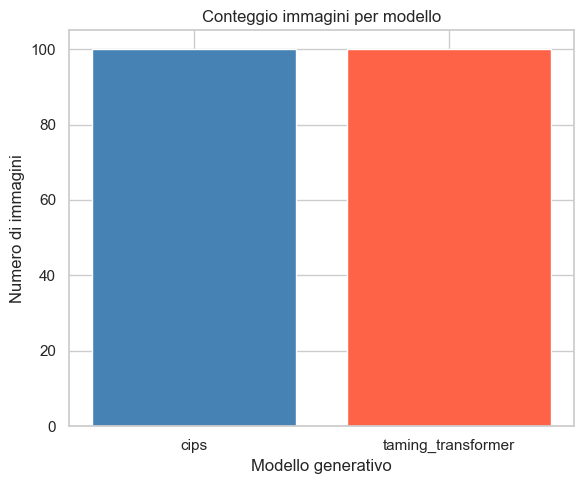

In [212]:
# Trasformazioni standard del modello ViT-B/16
transform = ViT_B_16_Weights.IMAGENET1K_V1.transforms()

# Caricamento del dataset con label numeriche e trasformazioni
dataset = ImageFolder(
    root_dir='./archive',
    model_a="cips",
    model_b="taming_transformer",
    nrows=100, 
    transform=transform
)

# DataLoader per batch processing
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Conversione dei sample in DataFrame
data = pd.DataFrame(dataset.samples, columns=['path', 'label'])

# Mapping esplicito per rendere leggibili le etichette numeriche
label_map = {0: 'cips', 1: 'taming_transformer'}
data['label_name'] = data['label'].map(label_map)

# Conteggio delle classi
counts = data['label_name'].value_counts().loc[['cips', 'taming_transformer']]

# Disegna il plot
fig, ax = plt.subplots(figsize=(6, 5))
ax.bar(counts.index, counts.values, color=['steelblue', 'tomato'])
ax.set_title("Conteggio immagini per modello")
ax.set_xlabel("Modello generativo")
ax.set_ylabel("Numero di immagini")
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### Estrazione delle features

In [213]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Carica il modello ViT-B/16 pre-addestrato
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)

# Rimuove la testa di classificazione
model.heads.head = nn.Identity()
model.eval().to(device)

all_feats = []
all_labels = []

# Estrazione feature senza gradienti
with torch.no_grad():
    for imgs, labs in tqdm(loader, desc="Estrazione delle feature"):
        imgs = imgs.to(device)
        feats = model(imgs)
        all_feats.append(feats.cpu().numpy())
        all_labels.extend(labs.numpy())

# Unione di tutte le feature in un'unica matrice
features = np.vstack(all_feats)
labels = np.array(all_labels)

# Creazione DataFrame finale
feat_cols = [f'feat_{i}' for i in range(features.shape[1])]
df = pd.DataFrame(features, columns=feat_cols)
df['label'] = labels

# Salva il DataFrame completo con tutte le feature originali per le operazioni successive come la PCA
feat_cols = [f'feat_{i}' for i in range(features.shape[1])]
df_full = pd.DataFrame(features, columns=feat_cols)
df_full['label'] = labels

# Debug: visualizza numero di esempi per classe
print(df.groupby('label').size())

Estrazione delle feature: 100%|██████████| 7/7 [00:28<00:00,  4.12s/it]

label
0    100
1    100
dtype: int64


In [214]:
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_759,feat_760,feat_761,feat_762,feat_763,feat_764,feat_765,feat_766,feat_767,label
0,-1.059680,0.647920,1.235340,0.655194,0.185727,0.261044,-0.086406,0.073612,-0.007544,-0.345334,...,-0.344391,-0.258088,0.139975,0.590006,1.008377,-0.828466,-1.118910,0.309175,-0.460052,0
1,-2.071830,-1.221225,0.434217,-0.106349,1.017357,0.088557,-0.929175,-0.048346,1.249109,1.382702,...,-0.039399,-0.486311,0.081941,0.493591,1.037179,-0.283892,-0.324540,-0.587197,0.201361,0
2,-2.280680,0.032495,1.114140,-0.936921,0.277405,0.970187,-0.404402,0.961688,-0.248145,-0.178796,...,0.105230,-0.562011,-0.197281,0.808425,-0.213554,-0.825744,-0.019083,-0.265228,-0.245730,0
3,-2.510967,-0.798528,0.244433,-0.242144,1.313727,0.808292,-0.709594,0.799947,-0.325061,1.228064,...,-0.068996,-0.237661,-0.241413,0.685905,0.427937,-0.361679,-0.669311,-0.047017,0.095566,0
4,0.060450,0.578819,0.201308,0.625400,0.324586,-0.022622,-0.058441,-0.104674,-0.063479,1.534172,...,0.049914,0.551623,0.183504,-0.294740,-0.425965,-0.438135,1.312542,-0.099938,0.662843,0


### Training

Split: Train=160, Val=20, Test=20
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params from validation: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Final Test Accuracy: 0.8500
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.77      1.00      0.87        10

    accuracy                           0.85        20
   macro avg       0.88      0.85      0.85        20
weighted avg       0.88      0.85      0.85        20

Confusion Matrix:
[[ 7  3]
 [ 0 10]]


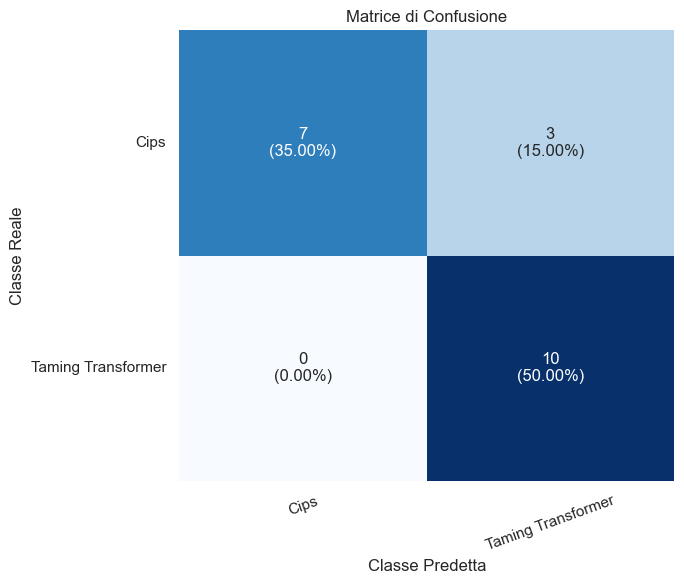

In [ ]:
df.__name__ = "df" 

# Crea la stringa nome modelli
model_name = f"{list(model_a)[0]}_vs_{list(model_b)[0]}"

# Crea output_dir
output_dir = get_unique_output_dir(model_name=model_name, dataset_name=df.__name__)

# Lancia il training passando output_dir
train_SVM(df, output_dir=output_dir)

Split: Train=119, Val=21, Test=60
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params from validation: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Final Test Accuracy: 0.8500
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84        30
           1       0.80      0.93      0.86        30

    accuracy                           0.85        60
   macro avg       0.86      0.85      0.85        60
weighted avg       0.86      0.85      0.85        60

Confusion Matrix:
[[23  7]
 [ 2 28]]


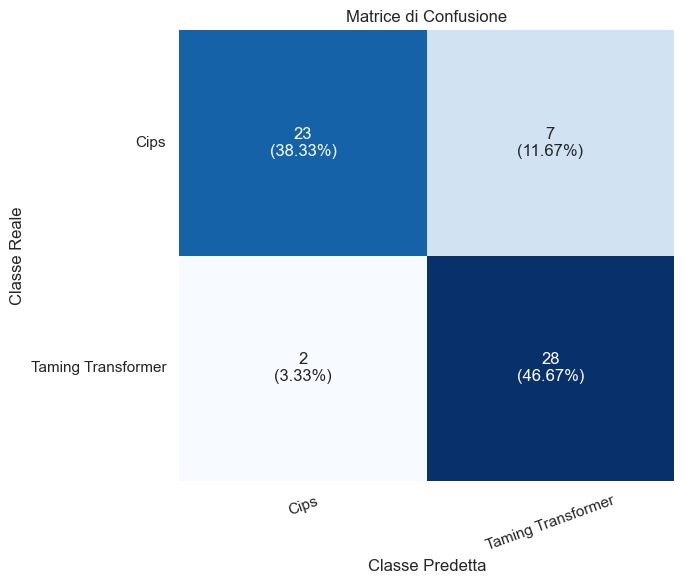

In [ ]:
df.__name__ = "df"  

# Crea la stringa tipo "cips_vs_taming_transformer"
model_name = f"{list(model_a)[0]}_vs_{list(model_b)[0]}"

# Crea output_dir con test_size incluso nel nome
output_dir = get_unique_output_dir(model_name=model_name, dataset_name=df.__name__,test_size=0.3)

# Lancia il training passando output_dir e test_size
train_SVM(df, output_dir=output_dir, test_size=0.3)


Split: Train=140, Val=20, Test=40
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params from validation: {'C': 10, 'coef0': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
Final Test Accuracy: 0.8750
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        20
           1       0.86      0.90      0.88        20

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.88      0.88      0.87        40

Confusion Matrix:
[[17  3]
 [ 2 18]]


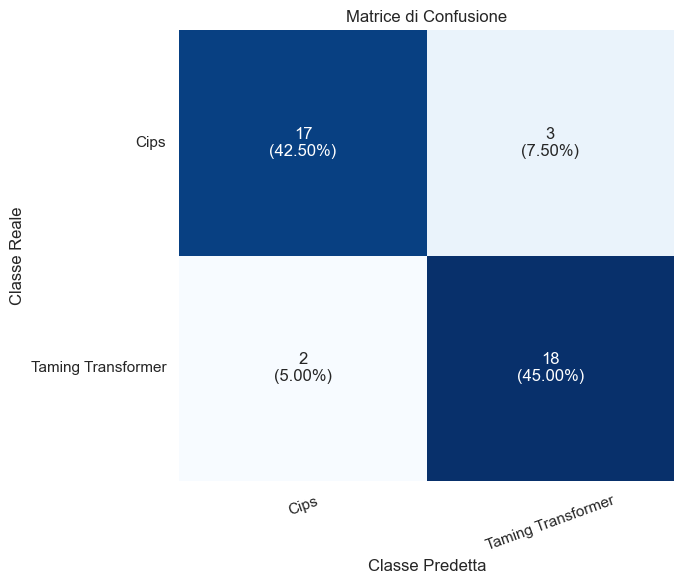

In [ ]:
df.__name__ = "df" 

# Crea la stringa tipo "cips_vs_taming_transformer"
model_name = f"{list(model_a)[0]}_vs_{list(model_b)[0]}"

# Crea output_dir con test_size incluso nel nome
output_dir = get_unique_output_dir(model_name=model_name, dataset_name=df.__name__,test_size=0.2)

# Lancia il training passando output_dir e test_size
train_SVM(df, output_dir=output_dir, test_size=0.2)


# Riduzione del numero delle features (PCA)

In [218]:
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features)
print(f"Shape dopo PCA: {features_pca.shape}")

Shape dopo PCA: (200, 3)


In [ ]:
df = pd.DataFrame(features_pca, columns=['PC1', 'PC2', 'PC3'])
df['label'] = labels

df.__name__ = "df_reduced"
model_name = f"{list(model_a)[0]}_vs_{list(model_b)[0]}"

fig = px.scatter_3d(
    df, x='PC1', y='PC2', z='PC3',
    color='label',
    title='PCA 3D Visualization',
    opacity=0.7
)
fig.show()

#Salvataggio plot 3D PCA
output_dir = get_unique_output_dir(model_name=model_name, dataset_name=df.__name__)
fig.write_html(os.path.join(output_dir, "pca_3d_plot.html"))



In [220]:
# Seleziona solo le colonne delle feature
feat_cols = [c for c in df_full.columns if c.startswith('feat_')]
X = df_full[feat_cols].values

# Fit completo della PCA per analizzare la varianza cumulativa
pca_full = PCA().fit(X)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)

# Determina quante componenti servono per spiegare almeno il 95% della varianza
n_components = np.argmax(cumvar >= 0.95) + 1
print(f"Numero di componenti per spiegare il 95% della varianza: {n_components}")

# Riduzione dimensionale con il numero ottimale di componenti
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Crea DataFrame con le componenti ridotte
pca_cols = [f'PC{i+1}' for i in range(n_components)]
df_pca = pd.DataFrame(X_pca, columns=pca_cols, index=df_full.index)

# Aggiungi le label
df_reduced = pd.concat([df_full[['label']], df_pca], axis=1)

# Visualizza info
print("Shape originale:", df_full.shape)
print("Shape ridotto:", df_reduced.shape)
df_reduced.head()

Numero di componenti per spiegare il 95% della varianza: 126
Shape originale: (200, 769)
Shape ridotto: (200, 127)


,label,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126
0,0,-10.635214,0.953834,-1.720656,-4.279091,-2.508063,-5.006454,1.152426,0.262193,-0.730240,...,-0.442617,-0.229446,-0.878703,0.423525,-0.369469,0.578152,-1.262138,-0.880780,-0.258954,-0.144477
1,0,-7.707935,-0.550752,-3.814920,10.576492,2.429671,-0.740964,0.737170,0.474370,1.424278,...,-0.476307,0.210978,0.201293,0.817379,-0.694067,0.710448,-0.295053,-1.069410,-0.586941,0.372476
2,0,-8.666769,1.402940,-5.121425,5.578957,-4.537533,-3.083179,-1.334209,1.827790,-1.195411,...,-0.436372,-0.219619,0.817931,-0.059211,-1.475607,0.011423,0.598188,-0.522540,-0.989330,-0.067377
3,0,-8.841763,-0.124366,-4.887685,6.228438,-0.587661,-4.711248,1.885072,0.209619,-1.018796,...,0.714742,0.257700,-0.285441,0.336896,-0.428840,-0.685213,-0.125255,0.504998,-0.590838,0.344156
4,0,8.796241,-8.488697,-4.096337,-1.319452,0.870832,0.413534,-1.998921,3.198292,-1.895543,...,-0.020774,-0.887295,0.441526,-0.594753,0.139555,-0.525460,0.468738,-0.940651,-0.243648,-0.268284


Split: Train=160, Val=20, Test=20
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params from validation: {'C': 0.1, 'kernel': 'linear'}
Final Test Accuracy: 0.9500
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20

Confusion Matrix:
[[ 9  1]
 [ 0 10]]


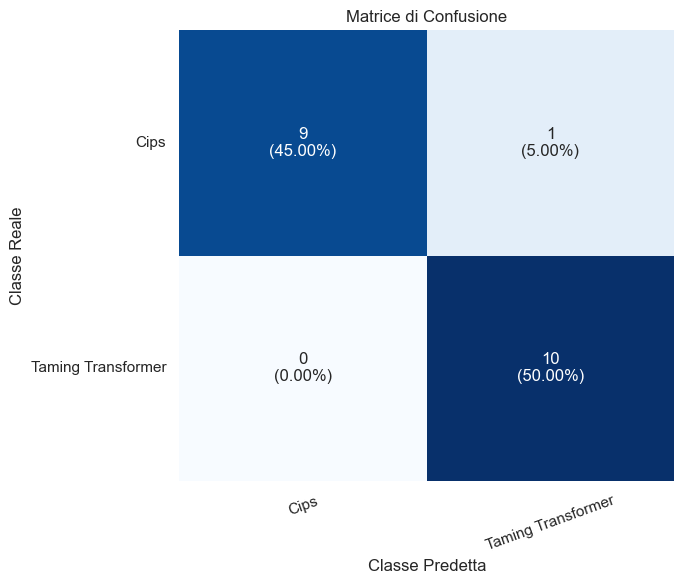

In [ ]:
df.__name__ = "df_reduced"  

# Crea la stringa tipo "cips_vs_taming_transformer"
model_name = f"{list(model_a)[0]}_vs_{list(model_b)[0]}"

# Crea output_dir con test_size incluso nel nome
output_dir = get_unique_output_dir(model_name=model_name, dataset_name=df.__name__)

# Lancia il training passando output_dir e test_size
train_SVM(df_reduced, output_dir=output_dir)


Split: Train=119, Val=21, Test=60
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params from validation: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Final Test Accuracy: 0.8667
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        30
           1       0.82      0.93      0.88        30

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60

Confusion Matrix:
[[24  6]
 [ 2 28]]


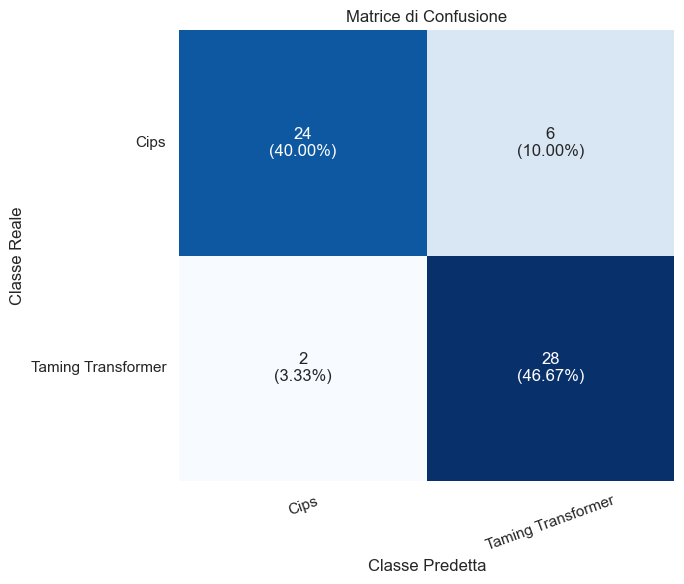

In [222]:

df.__name__ = "df_reduced"  

# Crea la stringa tipo "cips_vs_taming_transformer"
model_name = f"{list(model_a)[0]}_vs_{list(model_b)[0]}"


# Crea output_dir con test_size incluso nel nome
output_dir = get_unique_output_dir(model_name=model_name, dataset_name=df.__name__,  test_size=0.3)

# Lancia il training passando output_dir e test_size
train_SVM(df_reduced, test_size=0.3, output_dir=output_dir)

Split: Train=140, Val=20, Test=40
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params from validation: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Final Test Accuracy: 0.8500
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.75      0.83        20
           1       0.79      0.95      0.86        20

    accuracy                           0.85        40
   macro avg       0.86      0.85      0.85        40
weighted avg       0.86      0.85      0.85        40

Confusion Matrix:
[[15  5]
 [ 1 19]]


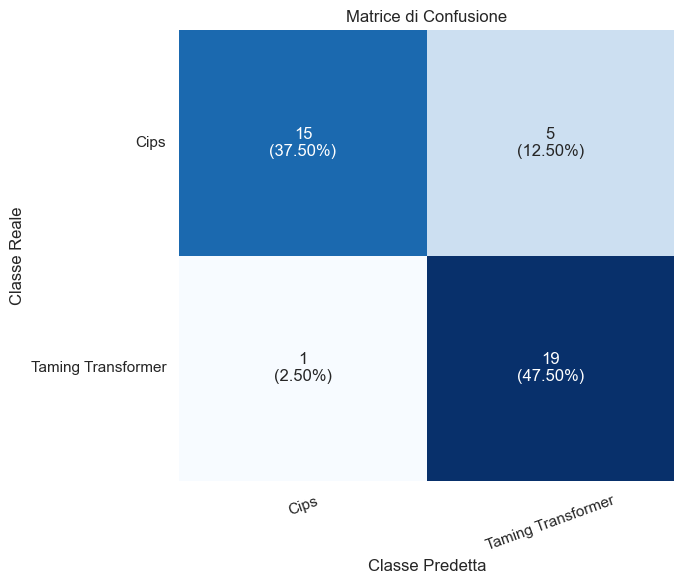

In [ ]:
df.__name__ = "df_reduced"  

# Crea la stringa tipo "cips_vs_taming_transformer"
model_name = f"{list(model_a)[0]}_vs_{list(model_b)[0]}"

# Crea output_dir con test_size incluso nel nome
output_dir = get_unique_output_dir(model_name=model_name, dataset_name=df.__name__,  test_size=0.2)

# Lancia il training passando output_dir e test_size
train_SVM(df_reduced, test_size=0.2, output_dir=output_dir)